En la página de FB Prophet (https://facebook.github.io/prophet/)se lee: "Prophet es un procedimiento para predecir datos de series temporales basado en un modelo aditivo en el que las tendencias no lineales se ajustan con estacionalidades anuales, semanales y diarias, además de efectos de días festivos. Funciona mejor con series temporales que tienen efectos estacionales fuertes y varios años de datos históricos. Prophet es resistente a datos faltantes y cambios en la tendencia, y generalmente maneja bien los valores atípicos".





*On the Facebook Prophet website (https://facebook.github.io/prophet/), you can read: "Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well."*

## *Libraries and data loading*

In [1]:
!pip install prophet

In [2]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Import libraries
import random
import os
import numpy as np
import pandas as pd
import requests

# Date
import datetime as dt
from datetime import date, timedelta, datetime
import time

# EDA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import math


# Time Series - EDA and Modelling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from itertools import product

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score


# Modeling and preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from prophet import Prophet
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

Utilizaremos el df creado en el capitulo anterior donde, además de las transformaciones, tenemos algunos indicadores de análisis técnico: las medias móviles y el RSI. Además, debemos recordar que el precio en la serie original fue desplazado un día hacia adelante, para una mejor predicción.

*We will use the DataFrame created in the previous chapter, where, in addition to the transformations, we have some technical analysis indicators: moving averages and the RSI. Additionally, it's important to remember that the price in the original series was shifted one day forward for improved prediction.*

In [3]:
df = pd.read_csv('df_BTC_MAs_and_RSI.csv',
            index_col = "date",
            parse_dates = True).asfreq("D")
df.head()

,original_series,diff,sqrt,inverse,log,squared,cubic,boxcox,yeo-johnson,MA25,MA50,EMA100,RSI
date,,,,,,,,,,,,,
2010-09-05,0.06160,-0.00078,0.248193,16.233766,-2.787093,0.003795,0.394936,-1.969850,-1.757090,0.065128,0.064282,0.058836,38.030468
2010-09-06,0.06100,0.00000,0.248193,16.233766,-2.787093,0.003795,0.394936,-1.969850,-1.757090,0.064912,0.064524,0.058891,40.427993
2010-09-07,0.06200,-0.00060,0.246982,16.393443,-2.796881,0.003721,0.393650,-1.970768,-1.757177,0.064576,0.064039,0.058945,38.764045
2010-09-08,0.06111,0.00100,0.248998,16.129032,-2.780621,0.003844,0.395789,-1.969243,-1.757031,0.064436,0.063643,0.058985,42.473118
2010-09-09,0.06180,-0.00089,0.247204,16.363934,-2.795080,0.003734,0.393886,-1.970599,-1.757161,0.064236,0.063388,0.059045,42.268593


## Preprocesamiento / *Preprocessing*

Confeccionamos el df con las columnas que utilizaremos como variables independientes, creamos una columna para el tiempo y renombramos la columna target según las convenciones de implementación del modelo Prophet, a saber, 'ds' para el tiempo e 'y' para la variable dependiente.

*We prepared the DataFrame with the columns that we will use as independent variables, created a column for time, and renamed the target column according to the implementation conventions of the Prophet model, namely, 'ds' for time and 'y' for the dependent variable.*

In [9]:
df_prophet = df[['original_series']].rename({'original_series':'y'}, axis='columns')
df_prophet['ds'] = df.index
df_prophet = df_prophet.join(df[['diff','log','yeo-johnson','MA25','MA50','EMA100','RSI']])


In [8]:
df_prophet.reset_index()

,date,y,ds,diff,log,yeo-johnson,MA25,MA50,EMA100,RSI
0,2010-09-05,0.06160,2010-09-05,-0.00078,-2.787093,-1.757090,0.065128,0.064282,0.058836,38.030468
1,2010-09-06,0.06100,2010-09-06,0.00000,-2.787093,-1.757090,0.064912,0.064524,0.058891,40.427993
2,2010-09-07,0.06200,2010-09-07,-0.00060,-2.796881,-1.757177,0.064576,0.064039,0.058945,38.764045
3,2010-09-08,0.06111,2010-09-08,0.00100,-2.780621,-1.757031,0.064436,0.063643,0.058985,42.473118
4,2010-09-09,0.06180,2010-09-09,-0.00089,-2.795080,-1.757161,0.064236,0.063388,0.059045,42.268593
...,...,...,...,...,...,...,...,...,...,...
4747,2023-09-04,25722.40000,2023-09-04,-292.50000,10.153098,1.190619,27059.644000,28274.506000,27932.444889,45.356844
4748,2023-09-05,25709.90000,2023-09-05,51.90000,10.155117,1.191613,26909.072000,28181.784000,27887.653901,50.604097
4749,2023-09-06,26146.70000,2023-09-06,-12.50000,10.154631,1.191373,26762.860000,28091.250000,27844.777586,43.273229
4750,2023-09-07,25890.60000,2023-09-07,436.80000,10.171478,1.199672,26615.220000,28009.300000,27802.502783,50.691313


*Train and test Split*

In [10]:
train = df_prophet[(df_prophet['ds'] < '2023-01-01')]
test = df_prophet[(df_prophet['ds'] >= '2023-01-01')]

## Modelo/ *Model*

In [11]:
# We train the model with its default parameterization
model = Prophet()
# We add the columns that we will use
model.add_regressor('diff')
model.add_regressor('log')
model.add_regressor('yeo-johnson')
model.add_regressor('MA25')
model.add_regressor('MA50')
model.add_regressor('EMA100')
model.add_regressor('RSI')

In [13]:
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxqyf5_40/730rv8c8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxqyf5_40/4gyg0_z5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24068', 'data', 'file=/tmp/tmpxqyf5_40/730rv8c8.json', 'init=/tmp/tmpxqyf5_40/4gyg0_z5.json', 'output', 'file=/tmp/tmpxqyf5_40/prophet_model0rhesapi/prophet_model-20231014152616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:26:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:26:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [19]:
#We create the prediction columns
pred = model.predict(test)
pred.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'EMA100', 'EMA100_lower', 'EMA100_upper', 'MA25', 'MA25_lower',
       'MA25_upper', 'MA50', 'MA50_lower', 'MA50_upper', 'RSI', 'RSI_lower',
       'RSI_upper', 'additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'diff', 'diff_lower', 'diff_upper',
       'extra_regressors_additive', 'extra_regressors_additive_lower',
       'extra_regressors_additive_upper', 'log', 'log_lower', 'log_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'yeo-johnson', 'yeo-johnson_lower', 'yeo-johnson_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [23]:
# We calcuate metrics

MAPE = mean_absolute_percentage_error(test['y'], pred['yhat']);
R2 = r2_score (test['y'], pred['yhat'])
print(f'R2_score = {R2}')
print(f'mean_absolute_percentage_error = {MAPE}')

R2_score = 0.829767510918507
mean_absolute_percentage_error = 0.041887792962581806


## Graficamos las predicciones/ *Plotting predictions*

In [26]:
# We create a univariable df for the test data
test_uni = pd.DataFrame({'ds': test['ds'], 'y': test['y']})

#  We create a univariable df for the train data
train_uni = pd.DataFrame({'ds': train['ds'], 'y': train['y']})

# We combine predicciones with univariable test data
df_combined = pd.concat([pred[pred['ds'].isin(test['ds'])].set_index('ds')['yhat'], test_uni.set_index('ds')['y']], axis=1)

In [37]:
df_combined.head(2)

,yhat,y
ds,,
2023-01-01,16657.482825,16692.9
2023-01-02,17110.134254,16670.7


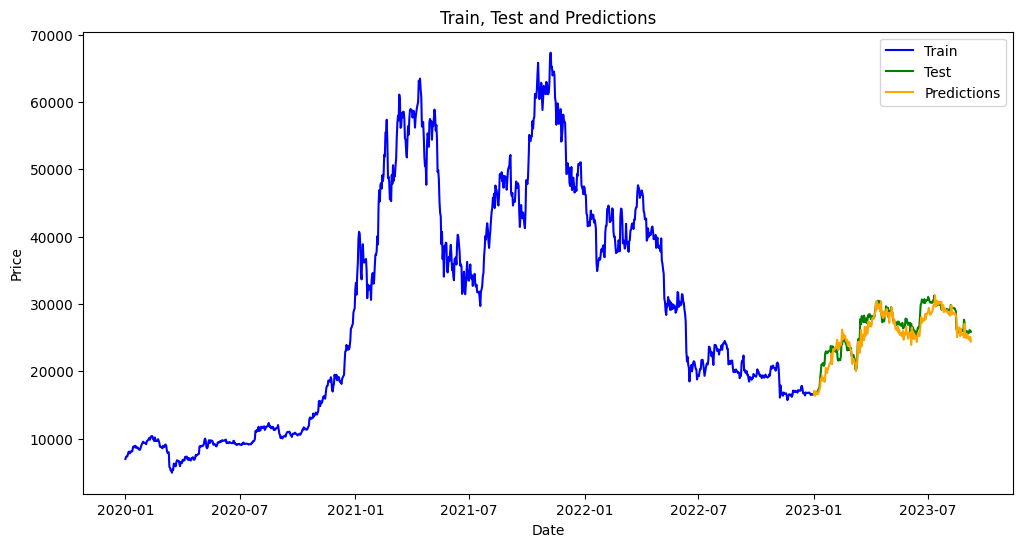

In [46]:
# We reduce the time range for the train data
start_date = pd.to_datetime('2020-01-01')

# we create a subset
train_uni_subset = train_uni[train_uni['ds'] >= start_date]

plt.figure(figsize=(12, 6))
plt.plot(train_uni_subset['ds'], train_uni_subset['y'], label='Train', color='blue')
plt.plot(test_uni['ds'], test_uni['y'], label='Test', color='green')
plt.plot(df_combined.index, df_combined['yhat'], label='Predictions', color='orange')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Train, Test and Predictions')
plt.show()

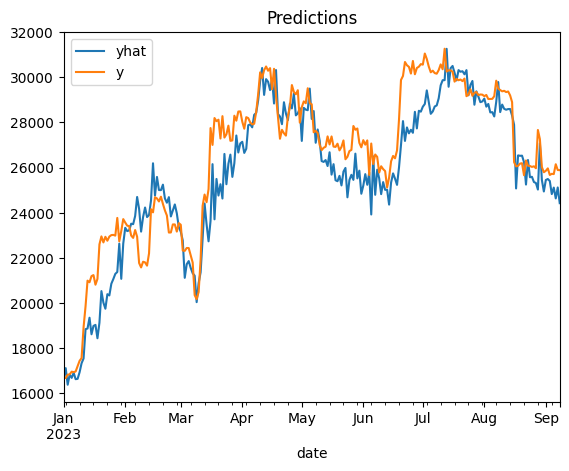

In [43]:
df_combined.plot()
plt.title('Predictions')
plt.xlabel('date')
plt.show()

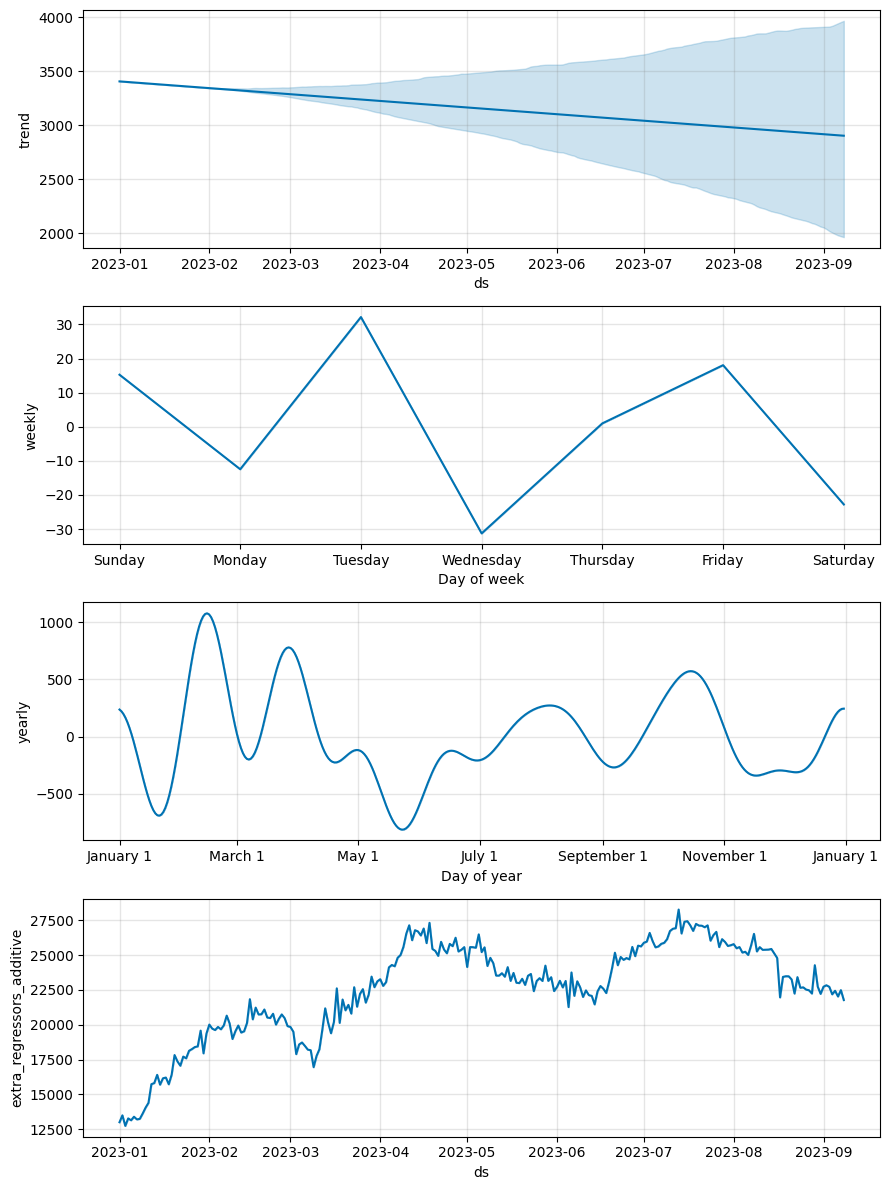

In [45]:
fig = model.plot_components(pred)
plt.tight_layout()

## Conclusión/ *Conclusion*

Este experimento ha utilizado el modelo Prophet con su parametrización por default y, aún así, podemos vislumbrar, si poderosa capacidad. En función de los resultados obtenidos, evaluados mediante las métricas MAPE (Mean Absolute Percentage Error) y R2 (R-squared), se puede concluir que el modelo ha demostrado un buen rendimiento en la predicción de la serie temporal. Obviamente esta primer aproximación debe ser reevaluada y revisada a partir de nuevos datos que pongan al descubierto posibles falencias.

*This experiment has employed the Prophet model with its default parameterization, and yet we can glimpse its powerful capability. Based on the results obtained, assessed through the MAPE (Mean Absolute Percentage Error) and R2 (R-squared) metrics, it can be concluded that the model has demonstrated good performance in time series prediction. Clearly, this initial approach must be reassessed and reviewed based on new data that may reveal potential shortcomings.*